In [1]:
import pandas as pd
import seaborn as sns
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import numpy as np

In [2]:
df = pd.read_csv("../final_good.csv")
df["CO2 Emissions (g)"] = df["CO2 Emissions (kg)"] * 1000
df = df.drop("CO2 Emissions (kg)", axis=1)
df.head()

,Flight ID,Aircraft Type,Departure Airport,Arrival Airport,Distance (km),Duration (hours),Cruising Altitude (ft),Wind Speed (km/h),Temperature (°C),SAF Percentage,Jet A-1 Percentage,Fuel Consumption (liters),Passenger Load,Cargo Load (kg),CO2 Emissions (g)
0,F0001,Boeing 777,LHR,MUC,2917,4.16,36890,116,36,0.088447,0.911553,27629,126,6349,82695940.0
1,F0002,Boeing 777,EDI,MXP,1067,1.38,31966,8,8,0.010645,0.989355,24324,346,9564,61440550.0
2,F0003,Boeing 787,BLQ,BCN,11180,16.11,30009,64,3,0.006474,0.993526,25948,162,5351,82779520.0
3,F0004,Airbus A350,FRA,LYS,6851,7.85,33703,49,0,0.021204,0.978796,33677,247,8512,92117270.0
4,F0005,Boeing 777,NAP,LHR,8087,10.01,37432,81,-10,0.070372,0.929628,22371,234,7284,66366410.0


In [3]:
print("Missing values per column:")
df.isnull().sum()

Missing values per column:


Flight ID                    0
Aircraft Type                0
Departure Airport            0
Arrival Airport              0
Distance (km)                0
Duration (hours)             0
Cruising Altitude (ft)       0
Wind Speed (km/h)            0
Temperature (°C)             0
SAF Percentage               0
Jet A-1 Percentage           0
Fuel Consumption (liters)    0
Passenger Load               0
Cargo Load (kg)              0
CO2 Emissions (g)            0
dtype: int64

In [4]:
print("Summary statistics:")
df.describe()

Summary statistics:


,Distance (km),Duration (hours),Cruising Altitude (ft),Wind Speed (km/h),Temperature (°C),SAF Percentage,Jet A-1 Percentage,Fuel Consumption (liters),Passenger Load,Cargo Load (kg),CO2 Emissions (g)
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03
mean,6111.757600,8.273548,35560.153600,59.400000,12.729600,0.040402,0.959598,20414.984800,199.681600,6218.450400,5.730575e+07
std,3378.397483,4.700575,3251.916066,34.497792,16.091988,0.032555,0.032555,9324.836602,88.063122,3252.033498,2.670454e+07
min,302.000000,0.360000,30001.000000,0.000000,-15.000000,0.000000,0.900096,5035.000000,50.000000,502.000000,1.289246e+07
25%,3238.000000,4.347500,32673.500000,31.000000,-1.000000,0.007483,0.930785,12186.750000,124.000000,3458.750000,3.423513e+07
50%,6019.000000,8.020000,35610.500000,59.000000,13.000000,0.037838,0.962162,20251.000000,198.500000,6176.500000,5.624576e+07
75%,9064.500000,12.052500,38445.500000,88.000000,27.000000,0.069215,0.992517,27831.500000,280.000000,8924.250000,7.814718e+07
max,11997.000000,19.880000,40999.000000,120.000000,40.000000,0.099904,1.000000,59888.000000,350.000000,11992.000000,1.759594e+08


## Checking for outliers


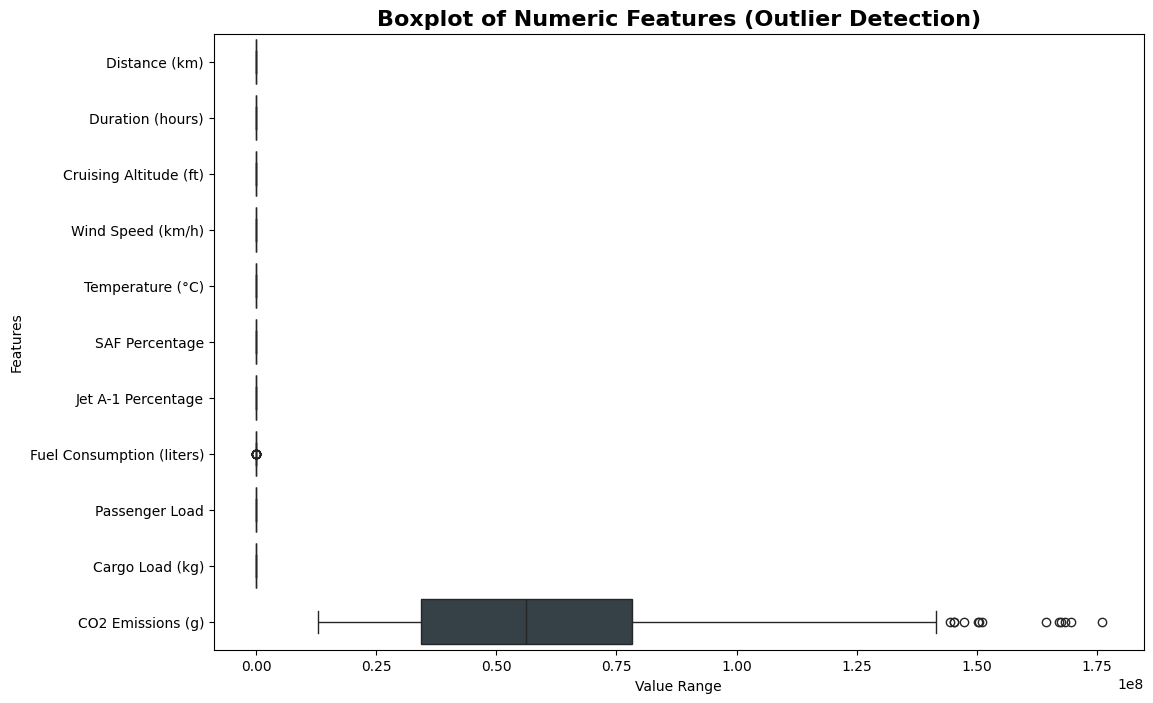

In [5]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numeric_cols], orient="h", palette="Blues_d")

plt.title("Boxplot of Numeric Features (Outlier Detection)", fontsize=16, weight="bold")
plt.xlabel("Value Range")
plt.ylabel("Features")
plt.show()

In [6]:
for col in numeric_cols:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

df.describe()

,Distance (km),Duration (hours),Cruising Altitude (ft),Wind Speed (km/h),Temperature (°C),SAF Percentage,Jet A-1 Percentage,Fuel Consumption (liters),Passenger Load,Cargo Load (kg),CO2 Emissions (g)
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2.500000e+03
mean,6111.669500,8.268535,35560.322000,59.399600,12.729600,0.040395,0.959605,20346.209400,199.680000,6218.569100,5.705279e+07
std,3376.749319,4.686004,3250.245827,34.469476,16.091988,0.032542,0.032542,9104.622305,88.023884,3249.359138,2.589614e+07
min,382.980000,0.519900,30104.950000,1.000000,-15.000000,0.000000,0.901463,5442.680000,52.000000,658.990000,1.544886e+07
25%,3238.000000,4.347500,32673.500000,31.000000,-1.000000,0.007483,0.930785,12186.750000,124.000000,3458.750000,3.423513e+07
50%,6019.000000,8.020000,35610.500000,59.000000,13.000000,0.037838,0.962162,20251.000000,198.500000,6176.500000,5.624576e+07
75%,9064.500000,12.052500,38445.500000,88.000000,27.000000,0.069215,0.992517,27831.500000,280.000000,8924.250000,7.814718e+07
max,11891.010000,18.350000,40923.050000,119.000000,40.000000,0.098537,1.000000,43179.220000,348.000000,11866.120000,1.179295e+08


In [7]:
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

df.head()

,Flight ID,Aircraft Type,Departure Airport,Arrival Airport,Distance (km),Duration (hours),Cruising Altitude (ft),Wind Speed (km/h),Temperature (°C),SAF Percentage,Jet A-1 Percentage,Fuel Consumption (liters),Passenger Load,Cargo Load (kg),CO2 Emissions (g)
0,F0001,Boeing 777,LHR,MUC,-0.946268,-0.876943,0.409183,1.642373,1.446375,1.476912,-1.476912,0.800060,-0.837213,0.040149,0.990429
1,F0002,Boeing 777,EDI,MXP,-1.494241,-1.470317,-1.106083,-1.491461,-0.293969,-0.914366,0.914366,0.436985,1.662609,1.029772,0.169471
2,F0003,Boeing 787,BLQ,BCN,1.501250,1.673715,-1.678785,0.133490,-0.604745,-1.042571,1.042571,0.615392,-0.428151,-0.267050,0.993657
3,F0004,Airbus A350,FRA,LYS,0.218991,-0.089334,-0.571555,-0.301765,-0.791210,-0.589835,0.589835,1.464471,0.537689,0.705951,1.354314
4,F0005,Boeing 777,NAP,LHR,0.585097,0.371705,0.575973,0.626778,-1.412762,0.921356,-0.921356,0.222436,0.389972,0.327955,0.359725


In [8]:
df = df.drop("Flight ID", axis=1)

In [9]:
non_numeric_cols = df.select_dtypes(exclude=["float64", "int64"]).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['Aircraft Type', 'Departure Airport', 'Arrival Airport'], dtype='object')


In [10]:
df_encoded = pd.get_dummies(df, columns=non_numeric_cols)
df_encoded.head()

,Distance (km),Duration (hours),Cruising Altitude (ft),Wind Speed (km/h),Temperature (°C),SAF Percentage,Jet A-1 Percentage,Fuel Consumption (liters),Passenger Load,Cargo Load (kg),...,Arrival Airport_OSL,Arrival Airport_PMI,Arrival Airport_RTM,Arrival Airport_STN,Arrival Airport_SZG,Arrival Airport_TLS,Arrival Airport_VCE,Arrival Airport_VIE,Arrival Airport_VLC,Arrival Airport_ZRH
0,-0.946268,-0.876943,0.409183,1.642373,1.446375,1.476912,-1.476912,0.800060,-0.837213,0.040149,...,False,False,False,False,False,False,False,False,False,False
1,-1.494241,-1.470317,-1.106083,-1.491461,-0.293969,-0.914366,0.914366,0.436985,1.662609,1.029772,...,False,False,False,False,False,False,False,False,False,False
2,1.501250,1.673715,-1.678785,0.133490,-0.604745,-1.042571,1.042571,0.615392,-0.428151,-0.267050,...,False,False,False,False,False,False,False,False,False,False
3,0.218991,-0.089334,-0.571555,-0.301765,-0.791210,-0.589835,0.589835,1.464471,0.537689,0.705951,...,False,False,False,False,False,False,False,False,False,False
4,0.585097,0.371705,0.575973,0.626778,-1.412762,0.921356,-0.921356,0.222436,0.389972,0.327955,...,False,False,False,False,False,False,False,False,False,False


In [11]:
X = df_encoded.drop(["CO2 Emissions (g)"], axis=1)
y = df_encoded["CO2 Emissions (g)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [12]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, root_mean_squared_error


def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)


rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = {"alpha": [0.01, 0.1, 1, 10, 100, 1000]}

# Ridge Regression
ridge = Ridge()
grid_search_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1,
)
grid_search_ridge.fit(X_train, y_train)

# Print the best parameters and RMSE for Ridge and Lasso
print("Best Ridge alpha:", grid_search_ridge.best_params_)
print("Best Ridge RMSE:", -grid_search_ridge.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Ridge alpha: {'alpha': 10}
Best Ridge RMSE: 0.17479728169073122


In [13]:
best_ridge_model = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test)


rmse_test_ridge = rmse(y_test, y_pred_ridge)
print(f"Ridge Regression Test RMSE: {rmse_test_ridge}")

Ridge Regression Test RMSE: 0.16801158609816702


## Cross Validation for Ridge Regression

In [14]:
ridge_cv = Ridge(alpha=grid_search_ridge.best_params_["alpha"])

cv_scores = cross_val_score(ridge, X_train, y_train, scoring=rmse_scorer, cv=5)
mean_cv_rmse = -cv_scores.mean()
std_cv_rmse = cv_scores.std()

print(f"Mean Cross-Validation RMSE: {mean_cv_rmse}")

Mean Cross-Validation RMSE: 0.1766405399814703


## Iteration, comparing other model with baseline model. 

### Random Forest Regressor

In [15]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = rmse(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf}")

Random Forest RMSE: 0.17241543886495625


### Gradient Boosting Regressor 

In [16]:
gb_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, random_state=42
)


gb_model.fit(X_train, y_train)



y_pred_gb = gb_model.predict(X_test)


rmse_gb = rmse(y_test, y_pred_gb)



print(f"Gradient Boosting RMSE: {rmse_gb}")

Gradient Boosting RMSE: 0.16770587304079285


### XGBoost Regressor

In [17]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = rmse(y_test, y_pred_xgb)
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 0.17913646869021582


### Cross - validation for random forest

In [18]:
rf_model_cv = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cv_scores = cross_val_score(
    rf_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5
)

rf_mean_cv_rmse = -rf_cv_scores.mean()
rf_std_cv_rmse = rf_cv_scores.std()


print(f"Random Forest Cross-Validation RMSE: {rf_mean_cv_rmse:.4f}")

Random Forest Cross-Validation RMSE: 0.1788


### Cross validation for Gradient Boostin

In [19]:
gb_model_cv = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, random_state=42
)


gb_cv_scores = cross_val_score(
    gb_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5
)



gb_mean_cv_rmse = -gb_cv_scores.mean()


gb_std_cv_rmse = gb_cv_scores.std()



print(f"Gradient Boosting Cross-Validation RMSE: {gb_mean_cv_rmse:.4f}")

Gradient Boosting Cross-Validation RMSE: 0.1758


In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

# Define the parameter distribution to search
param_distributions = {
    "n_estimators": [
        int(x) for x in np.linspace(start=50, stop=500, num=10)
    ],  # Random range for n_estimators
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],  # Different learning rates
    "max_depth": [3, 4, 5, 6, 7],  # Different max depths
    "subsample": [0.6, 0.75, 0.85, 0.9, 1.0],  # Different subsample rates
    "min_samples_split": [2, 5, 10, 15],  # Minimum samples to split
    "min_samples_leaf": [1, 2, 4, 6],  # Minimum samples in a leaf node
    "max_features": [
        "auto",
        "sqrt",
        "log2",
        None,
    ],  # Max features considered for splitting
}

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_gb = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of random combinations to try
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit RandomizedSearchCV to find the best parameters
random_search_gb.fit(X_train, y_train)

# Get the best parameters and the best score
best_gb_params = random_search_gb.best_params_
best_gb_rmse = -random_search_gb.best_score_

print("Best Parameters for Gradient Boosting Regressor (Random Search):")
print(best_gb_params)
print(f"Best Gradient Boosting RMSE (CV - Random Search): {best_gb_rmse:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\khush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\khush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\khush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\khush\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py"

Best Parameters for Gradient Boosting Regressor (Random Search):
{'subsample': 0.6, 'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.01}
Best Gradient Boosting RMSE (CV - Random Search): 0.1800


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
import numpy as np


rmse_scorer = make_scorer(
    rmse, greater_is_better=False
)  # Custom RMSE scorer (negative for minimization)

# Define the parameter distribution to search
param_distributions = {
    "n_estimators": [
        int(x) for x in np.linspace(start=50, stop=500, num=10)
    ],  # Random range for n_estimators
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],  # Different learning rates
    "max_depth": [3, 4, 5, 6, 7],  # Different max depths
    "subsample": [0.6, 0.75, 0.85, 0.9, 1.0],  # Different subsample rates
    "min_samples_split": [2, 5, 10, 15],  # Minimum samples to split
    "min_samples_leaf": [1, 2, 4, 6],  # Minimum samples in a leaf node
    "max_features": ["sqrt", "log2", None],  # Max features considered for splitting
}

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_gb_1 = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_distributions,
    n_iter=20,  # Number of random combinations to try
    scoring=rmse_scorer,  # Use the custom RMSE scorer
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# Fit RandomizedSearchCV to find the best parameters
random_search_gb_1.fit(X_train, y_train)

# Get the best parameters and the best score
best_gb_params = random_search_gb_1.best_params_

best_gb_rmse = (
    -random_search_gb_1.best_score_
)  # Negated because RMSE is negative for minimization

print("Best Parameters for Gradient Boosting Regressor (Random Search with RMSE):")
print(best_gb_params)
print(f"Best Gradient Boosting RMSE (CV - Random Search): {best_gb_rmse:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for Gradient Boosting Regressor (Random Search with RMSE):
{'subsample': 0.9, 'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 4, 'learning_rate': 0.05}
Best Gradient Boosting RMSE (CV - Random Search): 0.1801


### Cross validation fro XGBoost

In [22]:
xgb_model_cv = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_cv_scores = cross_val_score(
    xgb_model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5
)

xgb_mean_cv_rmse = -xgb_cv_scores.mean()
xgb_std_cv_rmse = xgb_cv_scores.std()

print(f"XGBoost Cross-Validation RMSE: {xgb_mean_cv_rmse:.4f}")

XGBoost Cross-Validation RMSE: 0.1842


## Comparing all the models

In [23]:
rmse_data = {
    "Model": ["Ridge Regression", "Random Forest", "Gradient Boosting", "XGBoost"],
    "RMSE": [rmse_test_ridge, rmse_rf, rmse_gb, rmse_xgb],
    "RMSE_CV": [mean_cv_rmse, rf_mean_cv_rmse, gb_mean_cv_rmse, xgb_mean_cv_rmse],
}

rmse_df = pd.DataFrame(rmse_data)


rmse_df

,Model,RMSE,RMSE_CV
0,Ridge Regression,0.168012,0.176641
1,Random Forest,0.172415,0.178833
2,Gradient Boosting,0.167706,0.175818
3,XGBoost,0.179136,0.184164


## plotting the actuall vs Predicted scores. 

In [24]:
y_test_sorted = np.sort(y_test)
y_test_sorted_index = next(i for i, x in enumerate(y_test_sorted) if x > 0)
y_test_sorted_index

258

In [25]:
y_pred_sorted_gb = np.sort(y_pred_gb)
y_pred_sorted_gb_index = next(i for i, x in enumerate(y_pred_sorted_gb) if x > 0)
y_pred_sorted_gb_index

249

In [26]:
split_index = max(y_test_sorted_index, y_pred_sorted_gb_index)

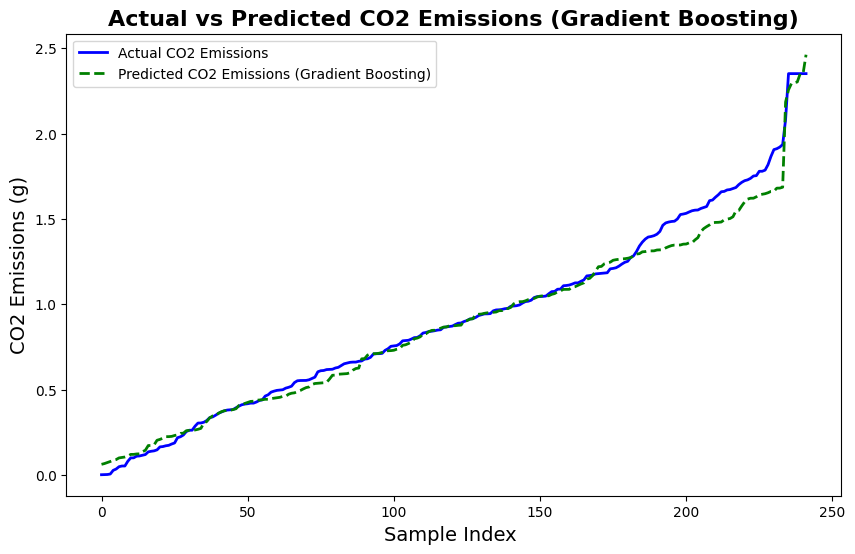

In [27]:
y_test_sorted = y_test_sorted[split_index:]
y_pred_sorted_gb = y_pred_sorted_gb[split_index:]

plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted, label="Actual CO2 Emissions", color="blue", linewidth=2)
plt.plot(
    y_pred_sorted_gb,
    label="Predicted CO2 Emissions (Gradient Boosting)",
    color="green",
    linestyle="--",
    linewidth=2,
)

plt.title(
    "Actual vs Predicted CO2 Emissions (Gradient Boosting)", fontsize=16, weight="bold"
)
plt.xlabel("Sample Index ", fontsize=14)
plt.ylabel("CO2 Emissions (g)", fontsize=14)
plt.legend()
plt.show()

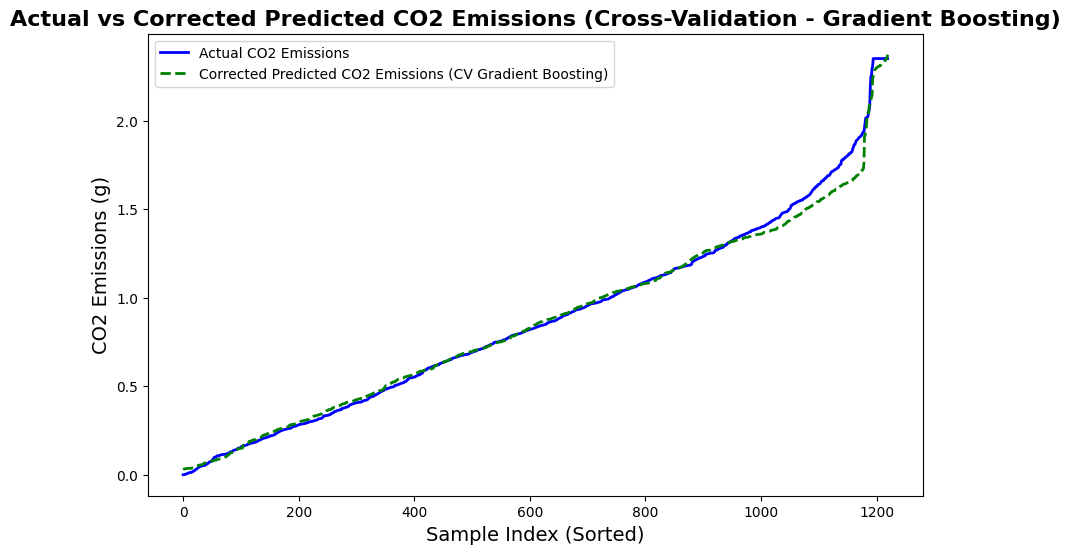

In [28]:
import numpy as np

gb_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, random_state=42
)
y_pred_cv_gb = cross_val_predict(gb_model, X, y, cv=5)

y_pred_cv_gb_corrected = np.maximum(y_pred_cv_gb, 0)


y_sorted = np.sort(y)
y_sorted_index = next(i for i, x in enumerate(y_sorted) if x > 0)

y_pred_cv_gb_sorted_corrected = np.sort(y_pred_cv_gb_corrected)
y_pred_cv_gb_sorted_corrected_index = next(
    i for i, x in enumerate(y_pred_cv_gb_sorted_corrected) if x > 0
)

split_index = max(y_sorted_index, y_pred_cv_gb_sorted_corrected_index)
y_sorted = y_sorted[split_index:]
y_pred_cv_gb_sorted_corrected = y_pred_cv_gb_sorted_corrected[split_index:]

plt.figure(figsize=(10, 6))
plt.plot(y_sorted, label="Actual CO2 Emissions", color="blue", linewidth=2)
plt.plot(
    y_pred_cv_gb_sorted_corrected,
    label="Corrected Predicted CO2 Emissions (CV Gradient Boosting)",
    color="green",
    linestyle="--",
    linewidth=2,
)


plt.title(
    "Actual vs Corrected Predicted CO2 Emissions (Cross-Validation - Gradient Boosting)",
    fontsize=16,
    weight="bold",
)
plt.xlabel("Sample Index (Sorted)", fontsize=14)
plt.ylabel("CO2 Emissions (g)", fontsize=14)
plt.legend()
plt.show()

## Plotting the actual vs predicted score after cross validation 

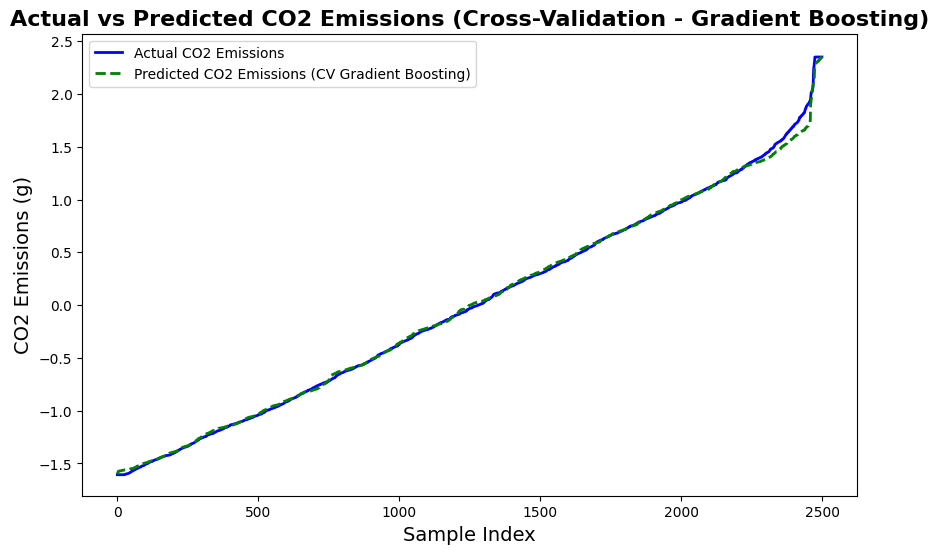

In [29]:
gb_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, random_state=42
)


y_pred_cv_gb = cross_val_predict(gb_model, X, y, cv=5)


y_sorted = np.sort(y)



y_pred_cv_gb_sorted = np.sort(y_pred_cv_gb)



plt.figure(figsize=(10, 6))


if len(y_pred_cv_gb_sorted) == len(y_sorted):


    plt.plot(y_sorted, label="Actual CO2 Emissions", color="blue", linewidth=2)

    plt.plot(
        y_pred_cv_gb_sorted,
        label="Predicted CO2 Emissions (CV Gradient Boosting)",
        color="green",
        linestyle="--",
        linewidth=2,
    )


else:

    print("Warning: Mismatch in length between actual and predicted values.")



plt.title(
    "Actual vs Predicted CO2 Emissions (Cross-Validation - Gradient Boosting)",
    fontsize=16,
    weight="bold",
)


plt.xlabel("Sample Index", fontsize=14)


plt.ylabel("CO2 Emissions (g)", fontsize=14)
plt.legend()



plt.show()

## MLFlow Logging 

In [30]:
MLFLOW_TRACKING_URI = "http://127.0.0.1:8080"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [31]:
with mlflow.start_run(run_name="Model Comparison_2"):
    mlflow.log_metric("Ridge Regression RMSE", rmse_test_ridge)
    mlflow.sklearn.log_model(ridge, "Ridge Regression Model")

    mlflow.log_metric("Random Forest RMSE", rmse_rf)
    mlflow.sklearn.log_model(rf_model, "Random Forest Model")

    mlflow.log_metric("Gradient Boosting RMSE", rmse_gb)
    mlflow.sklearn.log_model(gb_model, "Gradient Boosting Model")

    mlflow.log_metric("XGBoost RMSE", rmse_xgb)
    mlflow.sklearn.log_model(xgb_model, "XGBoost Model")

    rmse_df.to_csv("rmse_comparison.csv", index=False)
    mlflow.log_artifact("rmse_comparison.csv")

    mlflow.log_metric("Ridge Regression RMSE Cross Validation", mean_cv_rmse)
    mlflow.sklearn.log_model(ridge_cv, "Ridge Regression Model_cross validation")

    mlflow.log_metric("Random Forest_cross validation", rf_mean_cv_rmse)
    mlflow.sklearn.log_model(rf_model_cv, "Random forest cross validation")

    mlflow.log_metric("Gradient Boosting RMSE cross validation", gb_mean_cv_rmse)
    mlflow.sklearn.log_model(gb_model_cv, "Gradient Boosting Model cross validation")

    mlflow.log_metric("XGBoost RMSE cross validation", xgb_mean_cv_rmse)
    mlflow.sklearn.log_model(xgb_model_cv, "XGBoost Model cross validation")

print("Model metrics and artifacts logged in MLflow.")

MlflowException: API request to http://127.0.0.1:8080/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000193A9002E10>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [ ]:
with mlflow.start_run(run_name="Model Comparison_2"):
    mlflow.log_metric("Ridge Regression RMSE", rmse_test_ridge)
    mlflow.sklearn.log_model(ridge.fit(X_train, y_train), "Ridge Regression Model")

    mlflow.log_metric("Random Forest RMSE", rmse_rf)
    mlflow.sklearn.log_model(rf_model.fit(X_train, y_train), "Random Forest Model")

    mlflow.log_metric("Gradient Boosting RMSE", rmse_gb)
    mlflow.sklearn.log_model(gb_model.fit(X_train, y_train), "Gradient Boosting Model")

    mlflow.log_metric("XGBoost RMSE", rmse_xgb)
    mlflow.sklearn.log_model(xgb_model.fit(X_train, y_train), "XGBoost Model")

    rmse_df.to_csv("rmse_comparison.csv", index=False)
    mlflow.log_artifact("rmse_comparison.csv")

    mlflow.log_metric("Ridge Regression RMSE Cross Validation", mean_cv_rmse)
    mlflow.sklearn.log_model(
        ridge_cv.fit(X_train, y_train), "Ridge Regression Model_cross validation"
    )

    mlflow.log_metric("Random Forest_cross validation", rf_mean_cv_rmse)
    mlflow.sklearn.log_model(
        rf_model_cv.fit(X_train, y_train), "Random forest cross validation"
    )

    mlflow.log_metric("Gradient Boosting RMSE cross validation", gb_mean_cv_rmse)
    mlflow.sklearn.log_model(
        gb_model_cv.fit(X_train, y_train), "Gradient Boosting Model cross validation"
    )

    mlflow.log_metric("XGBoost RMSE cross validation", xgb_mean_cv_rmse)
    mlflow.sklearn.log_model(
        xgb_model_cv.fit(X_train, y_train), "XGBoost Model cross validation"
    )

print("Model metrics and artifacts logged in MLflow.")

In [ ]:
X_test.head(100).to_csv("test_set.csv", index=False)

In [ ]:
X_train.head()

,Distance (km),Duration (hours),Cruising Altitude (ft),Wind Speed (km/h),Temperature (°C),SAF Percentage,Jet A-1 Percentage,Fuel Consumption (liters),Passenger Load,Cargo Load (kg),...,Arrival Airport_OSL,Arrival Airport_PMI,Arrival Airport_RTM,Arrival Airport_STN,Arrival Airport_SZG,Arrival Airport_TLS,Arrival Airport_VCE,Arrival Airport_VIE,Arrival Airport_VLC,Arrival Airport_ZRH
2055,0.636932,0.446411,0.279628,0.307592,-1.723538,-0.072820,0.072820,-1.448259,-1.655336,0.499100,...,True,False,False,False,False,False,False,False,False,False
1961,0.520229,0.726023,0.421492,-0.998172,0.327583,-0.582678,0.582678,-0.301359,-0.814487,0.480939,...,False,False,False,False,False,False,False,False,False,False
1864,-1.060305,-1.075446,1.229592,-0.185697,1.570686,1.341305,-1.341305,1.011753,0.810397,1.397919,...,False,False,False,False,False,False,False,False,False,False
2326,-1.025057,-0.972993,1.434849,0.075456,1.322065,-1.241544,1.241544,1.096782,-0.666771,-1.306540,...,False,False,False,False,False,False,True,False,False,False
461,-0.730633,-0.838523,-0.527242,1.642373,0.576203,1.705624,-1.705624,-0.700686,-0.791762,1.458558,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df.columns

Index(['Flight ID', 'Aircraft Type', 'Departure Airport', 'Arrival Airport',
       'Distance (km)', 'Duration (hours)', 'Cruising Altitude (ft)',
       'Wind Speed (km/h)', 'Temperature (°C)', 'SAF Percentage',
       'Jet A-1 Percentage', 'Fuel Consumption (liters)', 'Passenger Load',
       'Cargo Load (kg)', 'CO2 Emissions (g)'],
      dtype='object')

In [ ]:
df["Arrival Airport"].sort_values().unique()

array(['AGP', 'AMS', 'ANR', 'ARN', 'BCN', 'BER', 'BLQ', 'BRU', 'BSL',
       'CDG', 'CPH', 'DUS', 'EDI', 'EIN', 'FAO', 'FCO', 'FRA', 'GVA',
       'HAM', 'HEL', 'INN', 'LGW', 'LHR', 'LIS', 'LYS', 'MAD', 'MAN',
       'MUC', 'MXP', 'NAP', 'NCE', 'OPO', 'ORY', 'OSL', 'PMI', 'RTM',
       'STN', 'SZG', 'TLS', 'VCE', 'VIE', 'VLC', 'ZRH'], dtype=object)

In [ ]:
gb_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
rmse_gb = rmse(y_test, y_pred_gb)
print(f"Gradient Boosting RMSE: {rmse_gb}")

Gradient Boosting RMSE: 0.16770587304079285


In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./models/saf_prediction_gb_model.pkl"

with open(model_pkl_file, "wb") as file:
    pickle.dump(gb_model, file)

In [ ]:
X_train.columns.to_list()

['Distance (km)',
 'Duration (hours)',
 'Cruising Altitude (ft)',
 'Wind Speed (km/h)',
 'Temperature (°C)',
 'SAF Percentage',
 'Jet A-1 Percentage',
 'Fuel Consumption (liters)',
 'Passenger Load',
 'Cargo Load (kg)',
 'Aircraft Type_Airbus A320',
 'Aircraft Type_Airbus A350',
 'Aircraft Type_Boeing 737',
 'Aircraft Type_Boeing 777',
 'Aircraft Type_Boeing 787',
 'Departure Airport_AGP',
 'Departure Airport_AMS',
 'Departure Airport_ANR',
 'Departure Airport_ARN',
 'Departure Airport_BCN',
 'Departure Airport_BER',
 'Departure Airport_BLQ',
 'Departure Airport_BRU',
 'Departure Airport_BSL',
 'Departure Airport_CDG',
 'Departure Airport_CPH',
 'Departure Airport_DUS',
 'Departure Airport_EDI',
 'Departure Airport_EIN',
 'Departure Airport_FAO',
 'Departure Airport_FCO',
 'Departure Airport_FRA',
 'Departure Airport_GVA',
 'Departure Airport_HAM',
 'Departure Airport_HEL',
 'Departure Airport_INN',
 'Departure Airport_LGW',
 'Departure Airport_LHR',
 'Departure Airport_LIS',
 'Departu